In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
# Load the dataset
df = pd.read_csv("weatherHistory.csv")

# Convert date column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

# Set date as index (optional but useful for plotting)
df.set_index('Formatted Date', inplace=True)

# Drop non-numeric columns that aren’t useful for prediction
df = df.drop(['Summary', 'Precip Type', 'Daily Summary', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', ], axis=1)

# Check for nulls and handle them
df = df.fillna(method='ffill')
df.head()


<ipython-input-4-00ad324d2ccf>:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
<ipython-input-4-00ad324d2ccf>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Temperature (C)
Formatted Date                            
2006-04-01 00:00:00+02:00         9.472222
2006-04-01 01:00:00+02:00         9.355556
2006-04-01 02:00:00+02:00         9.377778
2006-04-01 03:00:00+02:00         8.288889
2006-04-01 04:00:00+02:00         8.755556

In [6]:
# Feature Selection

features = df.columns.tolist()
target_col = 'Temperature (C)'

# Just for safety: remove target from input features
features.remove(target_col)
input_features = features + [target_col]  # put target at end for easier slicing later

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[input_features])


In [7]:
# Create Sequences for LSTM

def create_sequences(data, seq_length, target_index):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, target_index])  # predict temp
    return np.array(X), np.array(y)

seq_length = 30  # using past 30 days
target_index = input_features.index(target_col)

X, y = create_sequences(scaled_data, seq_length, target_index)


In [9]:
# Train test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [11]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(seq_length, len(input_features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 0.0060 - val_loss: 5.7605e-04
Epoch 2/5
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 86s 23ms/step - loss: 5.9671e-04 - val_loss: 3.2496e-04
Epoch 3/5
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - loss: 5.2214e-04 - val_loss: 3.2497e-04
Epoch 4/5
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - loss: 5.1519e-04 - val_loss: 3.0859e-04
Epoch 5/5
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step - loss: 4.8160e-04 - val_loss: 3.1166e-04


603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


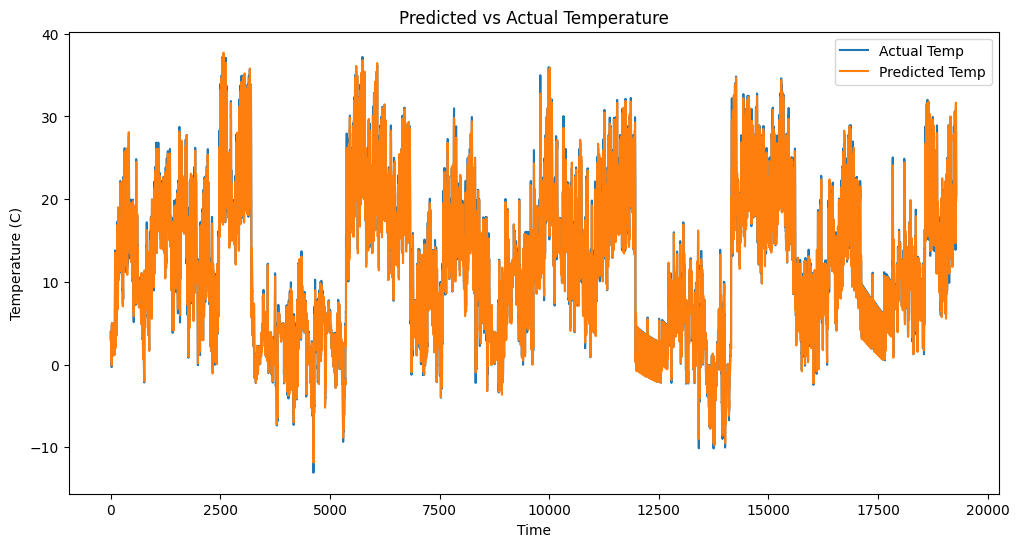

In [12]:
#  Evaluate and Visualize Predictions
predicted = model.predict(X_test)

# Inverse transform only the predicted temperature
predicted_temp = scaler.inverse_transform(
    np.hstack((np.zeros((predicted.shape[0], len(input_features)-1)), predicted))
)[:, -1]

actual_temp = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], len(input_features)-1)), y_test.reshape(-1,1)))
)[:, -1]

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual_temp, label='Actual Temp')
plt.plot(predicted_temp, label='Predicted Temp')
plt.title("Predicted vs Actual Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


In [13]:
# Predict Future Temperature (Next Day)
last_seq = scaled_data[-seq_length:]
last_seq = last_seq.reshape(1, seq_length, len(input_features))

future_pred = model.predict(last_seq)

# Inverse scale to get real temp
future_temp = scaler.inverse_transform(
    np.hstack((np.zeros((1, len(input_features)-1)), future_pred))
)[0, -1]

print(f"Predicted temperature for the next day: {future_temp:.2f} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted temperature for the next day: 19.09 °C


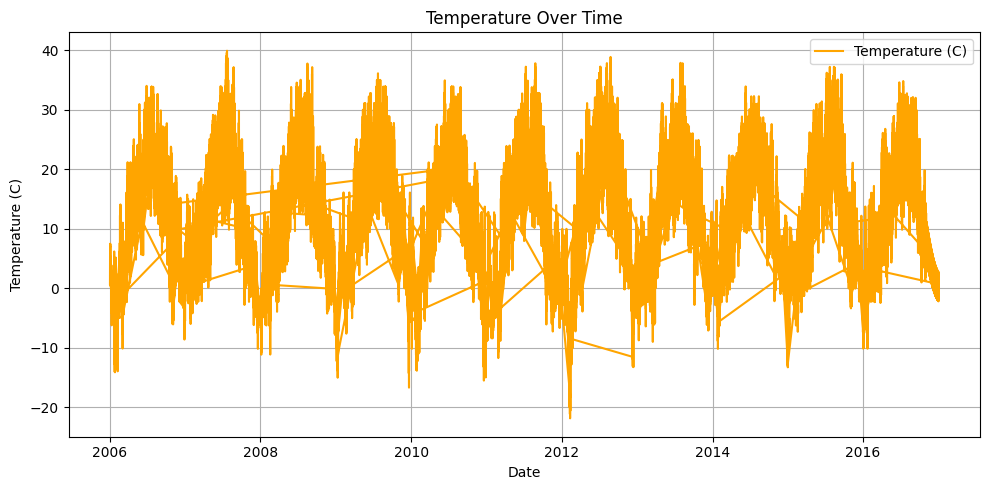

In [14]:
# Temperature over time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Temperature (C)"], label="Temperature (C)", color='orange')
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()